구조화된 데이터는 스프레드 시트나 관계형 데이터베이스에 있는 필드가 있는 데이터를 말합니다. 컬럼은 값의 타입을 나타내고 로우는 새로운 entry를 말합니다. 보통 이러한 타입의 데이터는 전통적인 통계 분석에 사용됩니다.

일살에서 구조화된 데이터는 비즈니스에서 자주 쓰이고 finance에서 해결해야하는 대부분의 머신 러닝 문제는 구조화된 데이터를 여러가지 방식으로 다룹니다. 주문, 거래, 옵션가, 수급 등 모든 정보들은 스프레드시트나 데이터베이스에 수집됩니다.

이번 챕터에서는 구조화된 데이터를의 문제를 credit card fraud로 다룰 것입니다. 

## The data

payment 시뮬레이터에 의해 생성된 인위의 거래 데이터셋을 사용합니다. fraudulent transaction을 찾기 위해 많은 finance 기관에서 사용하는 클래식한 ML 방법을 쓰겠습니다.

데이터셋 링크: https://www.kaggle.com/ntnu-testimon/paysim1/data

휴리스틱 모델은 빠르고 쉽게 만들 수 있지만 멍청하고 쉽게 사기꾼에게 접수 당합니다. 예로 200,000$에 금액에 대해 휴리스틱 모델을 설정하였다면 199,999$는 디텍션을 피할 수 있습니다. 

E2E 모델은 전문가의 지식없이 순수하게 수집된 데이터로 부터 학습합니다.  

## The heuristric approach

In [10]:
import numpy as np
import pandas as pd

df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [11]:
df['Fraud_Heuristic'] = np.where(((df['type'] == 'TRANSFER') & (df['amount'] > 200000)), 1,0)

## The F1 score

Actual Negative, Predicted Negative = True Negative  (TN)

Actual Negative, Predicted Positive = False Positive (FP)

Actual Positive, Predicted Negative = False Negative (FN)

Actual Positive, Predicted Negative = False Positive (TP)

precision = $TP \over TP + FP$

recall = $TP \over TP + FN$

F1 score는 두 값의 조화평균으로부터 계산된다. 

$F_1$ = $2 * {precision * recall \over precision + recall} $

In [12]:
from sklearn.metrics import f1_score

f1_score(y_pred = df['Fraud_Heuristic'], y_true = df['isFraud'])

0.013131315551742895

## Evaluation with a confusion matrix

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from tqdm import tqdm

In [14]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, origin='lower')
    plt.title(title)
    plt.colorbar()
    ax = plt.gca()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks([0, 1], target_names, rotation=45)
        plt.yticks([0, 1], target_names)
#         ax.xaxis.set_xticks(target_names)
#         ax.xaxis.set_yticks(target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout() 
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion.png')
    plt.show()

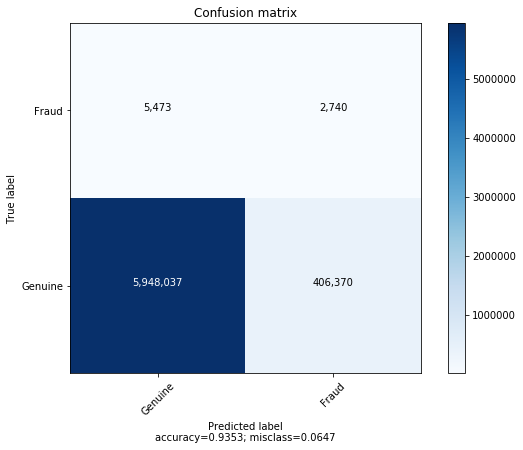

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=df['Fraud_Heuristic'],y_true=df['isFraud'])
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

## A feature from intuition - fraudster don't sleep

In [16]:
df['hour'] = df['step'] % 24

In [17]:
frauds = []
genuine = []
for i in range(24):
    f = len(df[(df['hour'] == i) & (df['isFraud'] == 1)])
    g = len(df[(df['hour'] == i) & (df['isFraud'] == 0)])
    frauds.append(f)
    genuine.append(g)

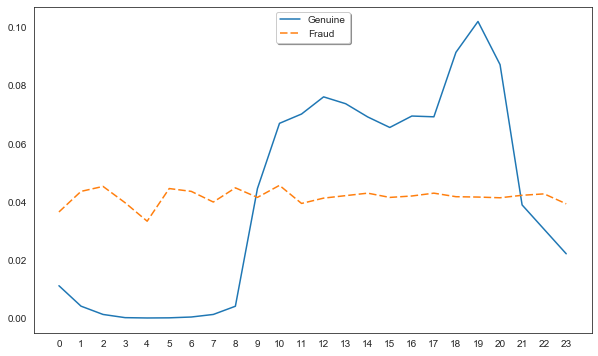

In [18]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,6))
gen = ax.plot(genuine/np.sum(genuine), label='Genuine')
fr = ax.plot(frauds/np.sum(frauds),dashes=[5, 2], label='Fraud')
#frgen = ax.plot(np.devide(frauds,genuine),dashes=[1, 1], label='Fraud vs Genuine')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper center', shadow=True)
fig.savefig('time.png')

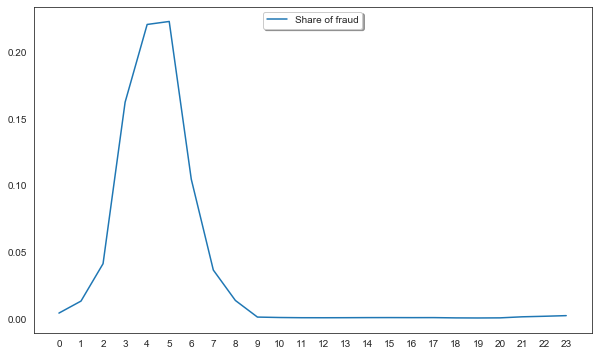

In [19]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,6))
#gen = ax.plot(genuine/np.sum(genuine), label='Genuine')
#fr = ax.plot(frauds/np.sum(frauds),dashes=[5, 2], label='Fraud')
frgen = ax.plot(np.divide(frauds,np.add(genuine,frauds)), label='Share of fraud')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper center', shadow=True)
fig.savefig('time_comp.png')

## Expert insight -transfer, then cash out

In [20]:
dfFraudTransfer = df[(df.isFraud == 1) & (df.type == 'TRANSFER')]

In [21]:
dfFraudCashOut = df[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

In [22]:
dfFraudTransfer.nameDest.isin(dfFraudCashOut.nameOrig).any()

False

In [23]:
dfNotFraud = df[(df.isFraud == 0)]

In [24]:
dfFraud = df[(df.isFraud == 1)]

In [25]:
dfFraudTransfer.loc[dfFraudTransfer.nameDest.isin(
    dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Fraud_Heuristic,hour
1030443,65,TRANSFER,1282971.57,C1175896731,1282971.57,0.0,C1714931087,0.0,0.0,1,0,1,17
6039814,486,TRANSFER,214793.32,C2140495649,214793.32,0.0,C423543548,0.0,0.0,1,0,1,6
6362556,738,TRANSFER,814689.88,C2029041842,814689.88,0.0,C1023330867,0.0,0.0,1,0,1,18


In [26]:
len(dfFraud[(dfFraud['oldbalanceDest'] == 0) & (dfFraud['newbalanceDest'] == 0) & (dfFraud['amount'])]) / (1.0 * len(dfFraud))

0.4955558261293072

In [27]:
len(dfNotFraud[(dfNotFraud['oldbalanceDest'] == 0) & (dfNotFraud['newbalanceDest'] == 0) & (dfNotFraud['amount'])]) / (1.0 * len(dfNotFraud))

0.36403176567065976

In [28]:
dfOdd = df[(df['oldbalanceDest'] == 0) & 
           (df['newbalanceDest'] == 0) & 
           (df['amount'])]

In [29]:
len(dfOdd[(dfOdd['isFraud'] == 1)]) / len(dfOdd)

0.0017563725684812685

## Entity embeddings

이 섹션에서 카테고리컬 데이터를 위한 임베딩 벡터를 만듭니다. 임베딩 벡터는 신경망의 입력으로 들어갑니다.

임베딩 레이어를 만들기 전에 인풋을 토크나이징 해야합니다. 그러기 위해서 map_dict을 생성해 토큰을 매핑합니다. 아래의 코드로 실행할 수 있습니다.

In [30]:
# Reload data
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [31]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [32]:
df = df.drop(['nameDest','nameOrig','step'],axis=1) # str이 포함된 것과 같은 필요없는 데이터 제외

In [33]:
# Tokenizing categorise

map_dict = {}
for token, value in enumerate(df['type'].unique()):
    map_dict[value] = token

In [34]:
print(map_dict)

{'PAYMENT': 0, 'TRANSFER': 1, 'CASH_OUT': 2, 'DEBIT': 3, 'CASH_IN': 4}


In [35]:
df["type"].replace(map_dict, inplace=True)

In [36]:
df.head()

,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,0,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,0,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,2,181.00,181.0,0.00,21182.0,0.0,1,0
4,0,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [37]:
other_cols = [c for c in df.columns if ((c != 'type') and (c != 'isFraud'))] # type isFraud 제외

In [38]:
other_cols

['amount',
 'oldBalanceOrig',
 'newBalanceOrig',
 'oldBalanceDest',
 'newBalanceDest',
 'isFlaggedFraud']

## Creating input models

In [39]:
from keras.models import Model
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Input 
from keras.layers import Concatenate

In [40]:
inputs = []
outputs = []

In [41]:
num_types = len(df['type'].unique())
type_embedding_dim = 3

In [42]:
type_in = Input(shape=(1,))
type_embedding = Embedding(num_types,type_embedding_dim,input_length=1)(type_in)
type_out = Reshape(target_shape=(type_embedding_dim,))(type_embedding)

type_model = Model(type_in,type_out)

inputs.append(type_in)
outputs.append(type_out)

In [43]:
num_rest = len(other_cols)

In [44]:
print(num_rest)

6


In [45]:
rest_in = Input(shape = (num_rest,))
rest_out = Dense(16)(rest_in)

rest_model = Model(rest_in,rest_out)

inputs.append(rest_in)
outputs.append(rest_out)

In [46]:
concatenated = Concatenate()(outputs)

In [47]:
x = Dense(16)(concatenated)
x = Activation('sigmoid')(x)
x = Dense(1)(concatenated)
model_out = Activation('sigmoid')(x)

In [48]:
merged_model = Model(inputs, model_out)
merged_model.compile(loss='binary_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])

## Traning the model

In [49]:
types = df['type']

In [50]:
rest = df[other_cols]

In [51]:
target = df['isFraud']

In [52]:
history = merged_model.fit([types.values,rest.values],target.values, 
                           epochs = 1, batch_size = 128)

49708/49708 [==============================] - 107s 2ms/step - loss: 230.0335 - accuracy: 0.9901


In [53]:
merged_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 3)         15          input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 3)            0           embedding[0][0]                  
____________________________________________________________________________________________

In [54]:
y_df = df['isFraud']
x_df = df.drop('isFraud',axis=1)

In [55]:
print(y_df)

0          0
1          0
2          1
3          1
4          0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 6362620, dtype: int64


In [56]:
print(x_df)

         type      amount  oldBalanceOrig  newBalanceOrig  oldBalanceDest  \
0           0     9839.64       170136.00       160296.36            0.00   
1           0     1864.28        21249.00        19384.72            0.00   
2           1      181.00          181.00            0.00            0.00   
3           2      181.00          181.00            0.00        21182.00   
4           0    11668.14        41554.00        29885.86            0.00   
...       ...         ...             ...             ...             ...   
6362615     2   339682.13       339682.13            0.00            0.00   
6362616     1  6311409.28      6311409.28            0.00            0.00   
6362617     2  6311409.28      6311409.28            0.00        68488.84   
6362618     1   850002.52       850002.52            0.00            0.00   
6362619     2   850002.52       850002.52            0.00      6510099.11   

         newBalanceDest  isFlaggedFraud  
0                  0.00          

In [57]:
y = y_df.values
X = x_df.values

In [58]:
y.shape

(6362620,)

In [59]:
X.shape

(6362620, 7)

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [63]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

데이터셋에 작은량의 fraudulent이 있기 때문에 oversampling이 필요합니다.

In [65]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [66]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

In [70]:
# Log reg
model = Sequential()
model.add(Dense(1, input_dim=7))
model.add(Activation('sigmoid'))

In [71]:
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-5), 
              metrics=['acc'])

In [72]:
model.fit(X_train_res,y_train_res,
          epochs=5, 
          batch_size=256, 
          validation_data=(X_val,y_val))

Epoch 1/5
29935/29935 [==============================] - 46s 2ms/step - loss: 432065.8750 - acc: 0.8886 - val_loss: 132184.9844 - val_acc: 0.8277
Epoch 2/5
29935/29935 [==============================] - 49s 2ms/step - loss: 416635.4062 - acc: 0.8912 - val_loss: 138439.0781 - val_acc: 0.8252
Epoch 3/5
29935/29935 [==============================] - 47s 2ms/step - loss: 419467.7188 - acc: 0.8918 - val_loss: 232469.4531 - val_acc: 0.7813
Epoch 4/5
29935/29935 [==============================] - 46s 2ms/step - loss: 415617.4062 - acc: 0.8916 - val_loss: 170601.2188 - val_acc: 0.8178
Epoch 5/5
29935/29935 [==============================] - 46s 2ms/step - loss: 421345.5000 - acc: 0.8914 - val_loss: 2694157.5000 - val_acc: 0.6557


In [73]:
y_pred = model.predict(X_test)

In [74]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [75]:
f1_score(y_pred=y_pred,y_true=y_test)

0.007219930938604665

In [76]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)

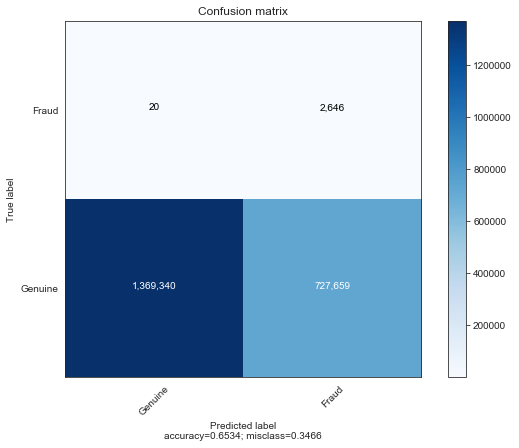

In [77]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

## Building more complex models
two-layer network

In [81]:
model = Sequential()
model.add(Dense(16, input_dim=7))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer =SGD(lr=1e-5),
              metrics=['acc'])

model.fit(X_train_res, y_train_res, epochs=5, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/5
29935/29935 [==============================] - 50s 2ms/step - loss: 0.8061 - acc: 0.5507 - val_loss: 0.5400 - val_acc: 0.7928
Epoch 2/5
29935/29935 [==============================] - 50s 2ms/step - loss: 0.6451 - acc: 0.6538 - val_loss: 0.5415 - val_acc: 0.8083
Epoch 3/5
29935/29935 [==============================] - 50s 2ms/step - loss: 0.5644 - acc: 0.6599 - val_loss: 0.5350 - val_acc: 0.8144
Epoch 4/5
29935/29935 [==============================] - 50s 2ms/step - loss: 0.5284 - acc: 0.6605 - val_loss: 0.5409 - val_acc: 0.7989
Epoch 5/5
29935/29935 [==============================] - 50s 2ms/step - loss: 0.4977 - acc: 0.7927 - val_loss: 0.4770 - val_acc: 0.8032


In [82]:
y_pred = model.predict(X_test)

In [83]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [84]:
f1_score(y_pred=y_pred,y_true=y_test)

0.010925356149875805

In [85]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)

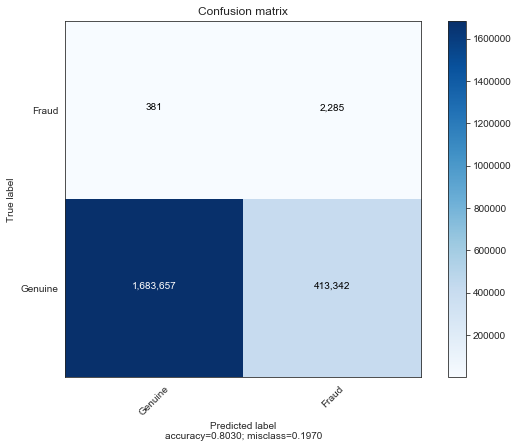

In [86]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

## Tree based methods

구조화된 데이터에선 tree-based methoed는 효과적입니다. 그러나 조금 더 고난도의 태스크에선 적합하지 않습니다.(이미지 인식이나 seq2seq과 같은)

https://xgboost.readthedocs.io 에 가면 XGBoost와 관련된 좋은 설명과 튜토리얼이 많으니 참고.

In [87]:
# Simple decision tree
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [97]:
# collection of decision tree 
from sklearn.ensemble import  RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [98]:
y_pred = rf.predict(X_test)

In [99]:
f1_score(y_pred=y_pred,y_true=y_test)

0.8601528609791366

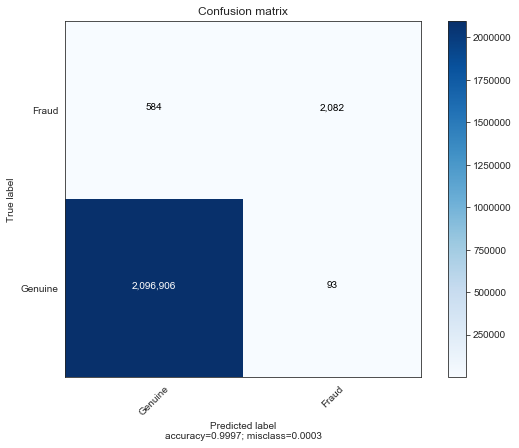

In [101]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [102]:
# xgboost 첫번째 트리가 만든 에러에 대해 두번 째 트리가 학습한다. 

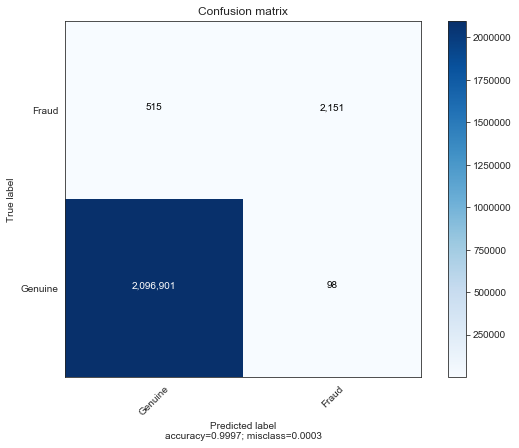

In [103]:
import xgboost as xgb
booster = xgb.XGBClassifier(n_jobs=-1)
booster = booster.fit(X_train,y_train)
y_pred = booster.predict(X_test)
f1_score(y_pred=y_pred,y_true=y_test)
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

랜덤 포레스트와 xgboost는 거의 비슷한 성능을 내는데 
두개 중 평균적으로 더 괜찮은 것을 선택하여 사용한다.

현실의 문제를 해결함에 있어 구조화된 데이터를 많이 사용하고 랜덤 포레스트와 gradient boosting은 표준적인 tool로 사용된다.
그러나 태스크가 복잡해지고 구조화되지 않은 데이터를 다룰 때 이 툴들은 실패한다. 